# Импорт библиотек

In [1]:
import sys
import os

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [2]:
sys.path.append('D:/Programming/Python')

In [3]:
from tools import show_correlation
from ml_tools import find_drop_features

# Импорт данных

In [4]:
os.listdir()

['Разбор реальной data science задачи.mp4',
 'russian_toxic_comments.ipynb',
 'russian_toxic_comments.csv',
 '.ipynb_checkpoints',
 '.git']

In [5]:
df = pd.read_csv("russian_toxic_comments.csv", sep=",")
df

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0


In [6]:
df.shape

(14412, 2)

# ML

## Обработка данных

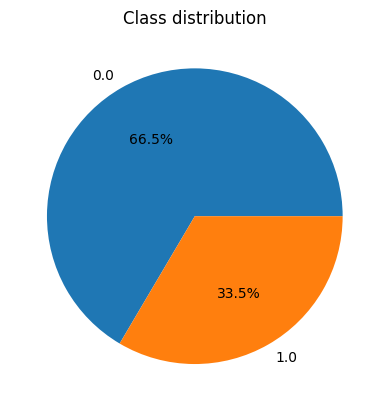

In [7]:
df['toxic'].value_counts().plot(kind='pie', title='Class distribution', autopct='%1.1f%%')
plt.axis('off')
plt.show()

### Приведение к одному типу

In [8]:
df["toxic"] = df["toxic"].apply(int)
df

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1
1,"Хохлы, это отдушина затюканого россиянина, мол...",1
2,Собаке - собачья смерть\n,1
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1
...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1


In [9]:
df["toxic"].value_counts()

toxic
0    9586
1    4826
Name: count, dtype: int64

In [10]:
for true_value in df[df['toxic'] == 1]['comment'].head(5):
    print(true_value)

Верблюдов-то за что? Дебилы, бл...

Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

Собаке - собачья смерть

Страницу обнови, дебил. Это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. Или мы в тебя верим - это ты и твои воображаемые друзья?

тебя не убедил 6-страничный пдф в том, что Скрипалей отравила Россия? Анализировать и думать пытаешься? Ватник что ли?)



In [11]:
for false_value in df[df['toxic'] == 0]['comment'].head(5):
    print(false_value)

В шапке были ссылки на инфу по текущему фильму марвел. Эти ссылки были заменены на фразу Репортим брипидора, игнорируем его посты. Если этого недостаточно, чтобы понять, что модератор абсолютный неадекват, и его нужно лишить полномочий, тогда эта борда пробивает абсолютное дно по неадекватности.

Почитайте посты у этого автора,может найдете что нибудь полезное. Надеюсь помог) https: pikabu.ru story obyichnyie budni dezsluzhbyi 4932098

Про графику было обидно) я так то проходил все серии гта со второй части по пятую, кроме гта 4. И мне не мешала графика ни в одной из частей. На компе у меня было куча видеокарт. Начиная с 32мб RIVA TNT и заканчивая 2Гб 560Ti на которой я спокойно играю который год в танки, гта5, ведьмака3 купил на распродаже и начал проходить. Да, не на ультрах. С пониженными текстурами. И не мешает. Я не понимаю дрочева на графике, требовать графику уровня плойки 4 минимум. Мне надо чтобы глаза не резало, только и всего. По поводу управления, мне не хватает переходника

In [12]:
# Преобразуем текстовые значения в числовые с помощью метода кодирования категориальных переменных
df_encoded = df.apply(lambda x: pd.factorize(x)[0])

# Вычисляем матрицу корреляции
correlation_matrix = df_encoded.corr()

correlation_matrix

,comment,toxic
comment,1.000000,0.161955
toxic,0.161955,1.000000


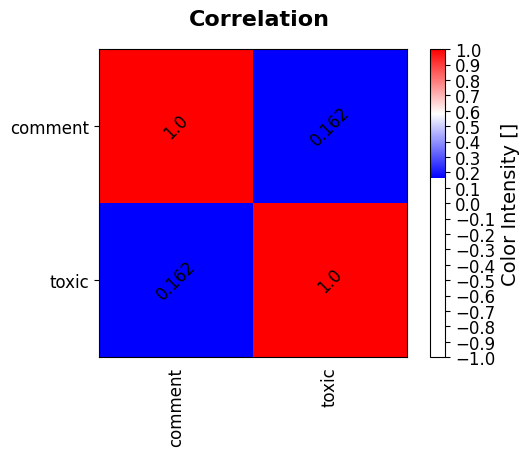

In [13]:
show_correlation(df_encoded, rnd=3, figsize=(6, 4))

In [14]:
features2drop = find_drop_features(correlation_matrix, threshold=0.9)
features2drop

[]

In [15]:
df.drop(features2drop,
        axis=1, inplace=True)
df

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1
1,"Хохлы, это отдушина затюканого россиянина, мол...",1
2,Собаке - собачья смерть\n,1
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1
...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1


In [16]:
df[df['comment'] == '']

,comment,toxic


In [17]:
df.duplicated().sum()

0

### Разделение данных на тренировочные и тестовые

In [18]:
train_df, test_df = train_test_split(df, test_size=500, shuffle=True, random_state=0)

In [19]:
test_df.shape

(500, 2)

In [20]:
test_df["toxic"].value_counts()

toxic
0    346
1    154
Name: count, dtype: int64

In [21]:
train_df["toxic"].value_counts()

toxic
0    9240
1    4672
Name: count, dtype: int64

### Токенизация

In [22]:
sentence_example = df.iloc[0]["comment"]
print(f"Исходный текст: {sentence_example}")

Исходный текст: Верблюдов-то за что? Дебилы, бл...



In [23]:
tokens = word_tokenize(sentence_example, language='russian') 
print(f"Токены: {tokens}")

Токены: ['Верблюдов-то', 'за', 'что', '?', 'Дебилы', ',', 'бл', '...']


### Удаление пунктуации

In [24]:
tokens_without_punctuation = [i for i in tokens if i not in string.punctuation]
print(f"Токены без пунктуации: {tokens_without_punctuation}")

Токены без пунктуации: ['Верблюдов-то', 'за', 'что', 'Дебилы', 'бл', '...']


### Удаление стоп-слов 

In [25]:
russian_stop_words = stopwords.words('russian')
tokens_without_russian_stop_words_and_punctuation = [i for i in tokens_without_punctuation if i not in russian_stop_words] 
print(f"Токены без пунктуации и стоп слов: {tokens_without_russian_stop_words_and_punctuation}")

Токены без пунктуации и стоп слов: ['Верблюдов-то', 'Дебилы', 'бл', '...']


### Стемминг = удаление окончаний

In [26]:
snowball = SnowballStemmer(language='russian')
stemmed_tokens = [snowball.stem(word) for word in tokens_without_russian_stop_words_and_punctuation] 
print(f"Токены после стемминга: {stemmed_tokens}")

Токены после стемминга: ['верблюдов-т', 'дебил', 'бл', '...']


In [27]:
print(f"Исходный текст: {sentence_example}")
print(f"Обработанный текст: {stemmed_tokens}")

Исходный текст: Верблюдов-то за что? Дебилы, бл...

Обработанный текст: ['верблюдов-т', 'дебил', 'бл', '...']


In [28]:
russian_stop_words = stopwords.words('russian')
snowball = SnowballStemmer(language='russian')

def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language = 'russian')
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

tokenize_sentence(sentence_example)

['верблюдов-т', 'дебил', 'бл', '...']

## TF-IDF = учет важность слова

TF-IDF — это метод векторизации признаков, широко используемый при анализе текста. TF-IDF помогает отразить важность слова как в документе, так и во всем корпусе. Корпус – это совокупность всех документов. TF-IDF состоит из двух компонентов: частоты термина (TF) и частоты обратного документа (IDF).

![](https://associatedpresscapstone.github.io/img/tfidf.png)

TF рассчитывается как отношение встречаемости слов к общему количеству слов в документе. 

IDF подсчитывается для каждого слова в словаре, а не в документе. 

N — количество документов в корпусе, 

DF — количество документов, в которых встречается это слово. Если слово встречается во всех документах, то IDF = 0.

In [29]:
vectorizer = CountVectorizer() 
vectorizer = TfidfVectorizer(tokenizer = lambda x: tokenize_sentence(x, remove_stop_words = True))
features = vectorizer.fit_transform(train_df['comment'])
features

c:\Python\Python 3.11.6\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<13912x35436 sparse matrix of type '<class 'numpy.float64'>'
	with 218998 stored elements in Compressed Sparse Row format>

## Обучение модели

In [30]:
model_sk = LogisticRegression(random_state=0)
model_sk.fit(features, train_df['toxic'])

LogisticRegression(random_state=0)

In [31]:
model_sk.predict(features[0])

array([0], dtype=int64)

In [32]:
train_df['comment'].iloc[0]

'Кровопускание уже вернулось:\n'

### Pipleine

![](https://spark-school.ru/wp-content/uploads/2021/01/ml-pipelinemodel2.png)

In [33]:
model_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer = lambda x: tokenize_sentence(x, remove_stop_words = True))),
    ('model', LogisticRegression(random_state = 0))
])

model_pipeline.fit(train_df['comment'], train_df['toxic'])

c:\Python\Python 3.11.6\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x0000024022EA9F80>)),
                ('model', LogisticRegression(random_state=0))])

In [34]:
model_pipeline.predict(["Привет, как дела?"])

array([0], dtype=int64)

In [35]:
model_pipeline.predict(["Слушай, а не пойти бы тебе?"])

array([1], dtype=int64)

## Оценка модели

Для оценки качества алгоритма на каждом из классов отдельно вводятся метрики точности Precision и полноты Recall.

![](https://hsto.org/getpro/habr/post_images/164/93b/c89/16493bc899f7275f3b5ff8d45a3ed2e2.svg)

Precision = доля объектов, названных классификатором положительными и в то же время действительно являющихся положительными. 

Recall = доля объектов положительного класса из всех объектов положительного класса нашел алгоритм.

![](https://sphire.mpg.de/wiki/lib/exe/fetch.php?cache=&media=pipeline:window:cryolo:precision_recall.png)

In [36]:
print(f"Precision: {precision_score(test_df['toxic'], model_pipeline.predict(test_df['comment']))}")
print(f"Recall: {recall_score(test_df['toxic'], model_pipeline.predict(test_df['comment']))}")

Precision: 0.9196428571428571
Recall: 0.6688311688311688


На самом деле модель логистической регрессии возвращает не принадлежность к классу, а вероятность нахождения в классе. И лишь только метод predict, сравнивая эту вероятность с порогом, относит его к конкретному клссу

In [37]:
# если вероятность (1 столбец) > порога (2 столбец) => 0 иначе 1
model_pipeline.predict_proba(test_df['comment']) 

array([[0.90119628, 0.09880372],
       [0.83693866, 0.16306134],
       [0.79336219, 0.20663781],
       [0.89812857, 0.10187143],
       [0.90408339, 0.09591661],
       [0.86907404, 0.13092596],
       [0.8823974 , 0.1176026 ],
       [0.68251943, 0.31748057],
       [0.88101372, 0.11898628],
       [0.44379173, 0.55620827],
       [0.26015918, 0.73984082],
       [0.49480994, 0.50519006],
       [0.73407931, 0.26592069],
       [0.38709455, 0.61290545],
       [0.85810737, 0.14189263],
       [0.9338285 , 0.0661715 ],
       [0.92180988, 0.07819012],
       [0.2069328 , 0.7930672 ],
       [0.92611356, 0.07388644],
       [0.90923927, 0.09076073],
       [0.79649526, 0.20350474],
       [0.83440976, 0.16559024],
       [0.8044926 , 0.1955074 ],
       [0.53692231, 0.46307769],
       [0.21130851, 0.78869149],
       [0.74876819, 0.25123181],
       [0.32179389, 0.67820611],
       [0.850319  , 0.149681  ],
       [0.97286737, 0.02713263],
       [0.84564622, 0.15435378],
       [0.

In [38]:
model_pipeline.predict(test_df['comment'])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,

In [39]:
prec, rec, thresholds = precision_recall_curve(test_df['toxic'], 
                                               model_pipeline.predict_proba(test_df['comment'])[:, 1])

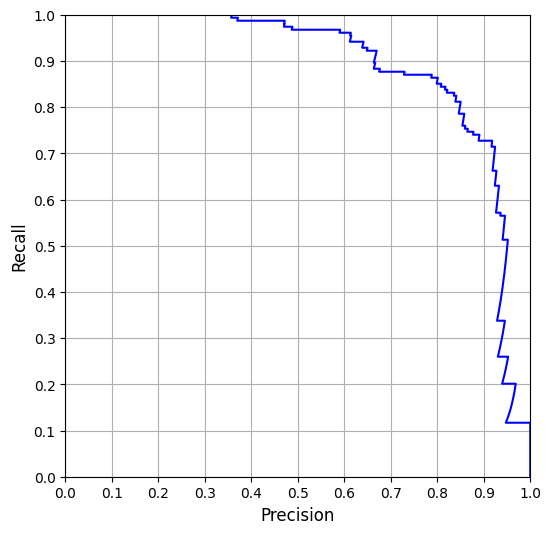

In [40]:
plt.figure(figsize=(6, 6))
plt.grid(True)
plt.plot(prec, rec, color='blue')
plt.xlabel('Precision', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks(np.linspace(0, 1, 10 + 1))
plt.yticks(np.linspace(0, 1, 10 + 1))
plt.show();

In [41]:
demand_precision = 0.95

In [42]:
np.where(prec > demand_precision)

(array([416, 417, 418, 457, 458, 467, 468, 469, 470, 471, 472, 473, 474,
        475, 476, 477, 478, 481, 482, 483, 484, 485, 486, 487, 488, 489,
        490, 491, 492, 493, 494, 495, 496, 497, 498], dtype=int64),)

In [43]:
demand_index = np.min(np.where(prec > demand_precision))
demand_index

416

In [44]:
print(f"Precision: {precision_score(test_df['toxic'], model_pipeline.predict_proba(test_df['comment'])[:, 1] > thresholds[demand_index])}")
print(f"Recall: {recall_score(test_df['toxic'], model_pipeline.predict_proba(test_df['comment'])[:, 1] > thresholds[demand_index])}")

Precision: 0.9512195121951219
Recall: 0.5064935064935064


## Улучшение модели

In [45]:
param_grid = {'C': [0.1, 1.0, 10.0]} # Коэф. регуляризации

grid_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer = lambda x: tokenize_sentence(x, remove_stop_words = True))),
    ('model',  GridSearchCV(LogisticRegression(random_state=0, max_iter=200), 
                            param_grid=param_grid, # параметры оптимизации
                            cv=3, # количество кросс-валидаций за одну итерацию 
                            verbose=4 # отображение всего прогресса 
                            ))
])

grid_pipeline.fit(train_df['comment'], train_df['toxic'])

c:\Python\Python 3.11.6\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END .............................C=0.1;, score=0.686 total time=   0.0s
[CV 2/3] END .............................C=0.1;, score=0.687 total time=   0.0s
[CV 3/3] END .............................C=0.1;, score=0.685 total time=   0.0s
[CV 1/3] END .............................C=1.0;, score=0.830 total time=   0.0s
[CV 2/3] END .............................C=1.0;, score=0.843 total time=   0.0s
[CV 3/3] END .............................C=1.0;, score=0.838 total time=   0.0s
[CV 1/3] END ............................C=10.0;, score=0.853 total time=   0.1s
[CV 2/3] END ............................C=10.0;, score=0.866 total time=   0.1s
[CV 3/3] END ............................C=10.0;, score=0.870 total time=   0.2s


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x0000024022EAA0C0>)),
                ('model',
                 GridSearchCV(cv=3,
                              estimator=LogisticRegression(max_iter=200,
                                                           random_state=0),
                              param_grid={'C': [0.1, 1.0, 10.0]}, verbose=4))])

In [46]:
C = 10

In [47]:
model_pipeline_c_10 = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer = lambda x: tokenize_sentence(x, remove_stop_words = True))),
    ('model', LogisticRegression(random_state = 0, C=C, max_iter=200))
])

model_pipeline_c_10.fit(train_df['comment'], train_df['toxic'])

c:\Python\Python 3.11.6\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x000002402701EC00>)),
                ('model',
                 LogisticRegression(C=10, max_iter=200, random_state=0))])

In [48]:
prec_c_10, rec_c_10, thresholds_c_10 = precision_recall_curve(test_df['toxic'], model_pipeline_c_10.predict_proba(test_df['comment'])[:, 1])

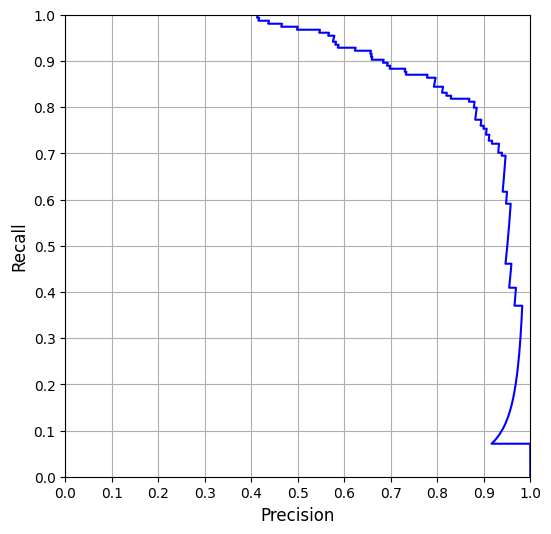

In [49]:
plt.figure(figsize=(6, 6))
plt.grid(True)
plt.plot(prec_c_10, rec_c_10, color='blue')
plt.xlabel('Precision', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks(np.linspace(0, 1, 10 + 1))
plt.yticks(np.linspace(0, 1, 10 + 1))
plt.show();

In [50]:
np.where(prec_c_10 > demand_precision)

(array([404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416,
        417, 418, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435,
        436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448,
        449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461,
        462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474,
        475, 476, 477, 478, 487, 488, 489, 490, 491, 492, 493, 494, 495,
        496, 497, 498], dtype=int64),)

In [51]:
demand_index = np.min(np.where(prec_c_10 > demand_precision))
demand_index

404

In [52]:
print(f"Precision: {precision_score(test_df['toxic'], model_pipeline_c_10.predict_proba(test_df['comment'])[:, 1] > thresholds_c_10[demand_index])}")
print(f"Recall: {recall_score(test_df['toxic'], model_pipeline_c_10.predict_proba(test_df['comment'])[:, 1] > thresholds_c_10[demand_index])}")

Precision: 0.9574468085106383
Recall: 0.5844155844155844


In [53]:
message = 'приехали'

In [54]:
if model_pipeline_c_10.predict([message]):
    print('toxic')
else:
    print('norm')

toxic


# NN

## Обработка данных

In [154]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['comment'].to_list())

In [155]:
sequences = tokenizer.texts_to_sequences(df['comment'].to_list())

In [156]:
maxlen = 300  # максимальная длина текста

padded_sequences = pad_sequences(sequences, maxlen=maxlen)

## Создание модели

In [208]:
output_dim = 100  # dimension of the hidden variable, i.e. the embedding dimension

In [214]:
model = Sequential()
model.add(layers.Embedding(input_dim=len(tokenizer.word_index) + 1, 
                           output_dim=output_dim))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

In [221]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=[keras.metrics.Accuracy(),
                       keras.metrics.Precision(), 
                       keras.metrics.Recall()])

In [222]:
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ (None, 300, 100)          │  6,849,100 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 64)                │     34,048 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_11 (Dense)                │ (None, 1)                 │         65 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 6,883,213 (26.26 MB)

 Trainable params: 6,883,213 (26.26 MB)

 Non-trainable params: 0 (0.00 B)

## Обучение модели

In [223]:
epochs = 100
batch_size = 256
verbose = True

callbacks = [keras.callbacks.EarlyStopping(monitor='accuracy', patience=5, min_delta=0.001, restore_best_weights=True)]

In [224]:
history = model.fit(padded_sequences, df['toxic'].to_numpy(),
                    validation_split=0.2,  
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=callbacks, 
                    verbose=verbose)

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - accuracy: 0.0000e+00 - loss: 0.1930 - precision_14: 0.9524 - recall_14: 0.90 ━━━━━━━━━━━━━━━━━━━━ 13s 306ms/step - accuracy: 0.0000e+00 - loss: 0.2042 - precision_14: 0.9379 - recall_14: 0.91 ━━━━━━━━━━━━━━━━━━━━ 12s 301ms/step - accuracy: 0.0000e+00 - loss: 0.2082 - precision_14: 0.9330 - recall_14: 0.91 ━━━━━━━━━━━━━━━━━━━━ 12s 304ms/step - accuracy: 0.0000e+00 - loss: 0.2090 - precision_14: 0.9328 - recall_14: 0.91 ━━━━━━━━━━━━━━━━━━━━ 12s 302ms/step - accuracy: 0.0000e+00 - loss: 0.2100 - precision_14: 0.9325 - recall_14: 0.91 ━━━━━━━━━━━━━━━━━━━━ 12s 302ms/step - accuracy: 0.0000e+00 - loss: 0.2103 - precision_14: 0.9326 - recall_14: 0.91 ━━━━━━━━━━━━━━━━━━━━ 11s 303ms/step - accuracy: 0.0000e+00 - loss: 0.2104 - precision_14: 0.9317 - recall_14: 0.91 ━━━━━━━━━━━━━━━━━━━━ 11s 301ms/step - accuracy: 0.0000e+00 - loss: 0.2103 - precision_14: 0.9314 - recall_14: 0.91 ━━━━━━━━━━━━━━━━━━━━ 11s 302ms/step - accuracy: 0.0000e+00 - los

In [229]:
print('\nhistory dict:', history.history)


history dict: {'accuracy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'loss': [0.1884009689092636, 0.09915977716445923, 0.054401904344558716, 0.03294419124722481, 0.022930873557925224, 0.018084855750203133], 'precision_14': [0.9190241098403931, 0.9525873064994812, 0.9746478796005249, 0.983846127986908, 0.991230309009552, 0.9937936663627625], 'recall_14': [0.9145144820213318, 0.96513432264328, 0.9829545617103577, 0.9909607172012329, 0.9925103187561035, 0.9925103187561035], 'val_accuracy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'val_loss': [0.2705376446247101, 0.29564300179481506, 0.2999362349510193, 0.3634975850582123, 0.3842676877975464, 0.3666110336780548], 'val_precision_14': [0.8995097875595093, 0.9152542352676392, 0.8386411666870117, 0.924221932888031, 0.9141689538955688, 0.875], 'val_recall_14': [0.7693920135498047, 0.7358490824699402, 0.8280922174453735, 0.7159329056739807, 0.7033542990684509, 0.7704402804374695]}


## Тестирование

In [225]:
sms = ['Верблюдов-то за что? Дебилы, бл...',
       'Прогноз на сегодня - солнечно',
       'Я убью тебя!',
       'Я люблю тебя!',
       'Кодишь отвратительно как старый пердун!']

In [226]:
sms = tokenizer.texts_to_sequences(sms)

In [227]:
sms = pad_sequences(sms, maxlen=maxlen)

In [228]:
model.predict(sms)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


array([[0.7378042 ],
       [0.61043066],
       [0.8493289 ],
       [0.7316104 ],
       [0.6432643 ]], dtype=float32)